# Model fitting 1: Only SSC

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [2]:
print(jetset.__version__)

1.3.0rc9


In [3]:
test_SEDs

['/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [4]:
print(test_SEDs[1])
data=Data.from_file(test_SEDs[1])


/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv



***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2



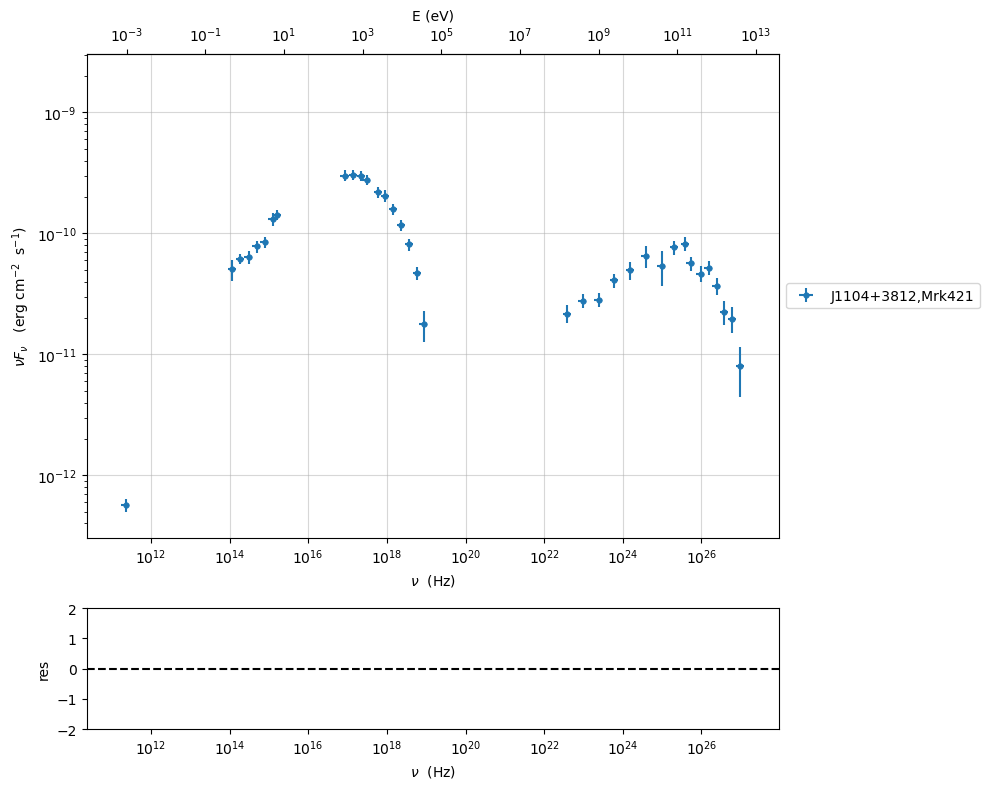

In [5]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()
#p.setlim(y_min=1E-15,x_min=1E7,x_max=1E29)

In [6]:
sed_data.save('Mrk_401.pkl')

## phenomenological model constraining

### spectral indices


*** evaluating spectral indices for data ***



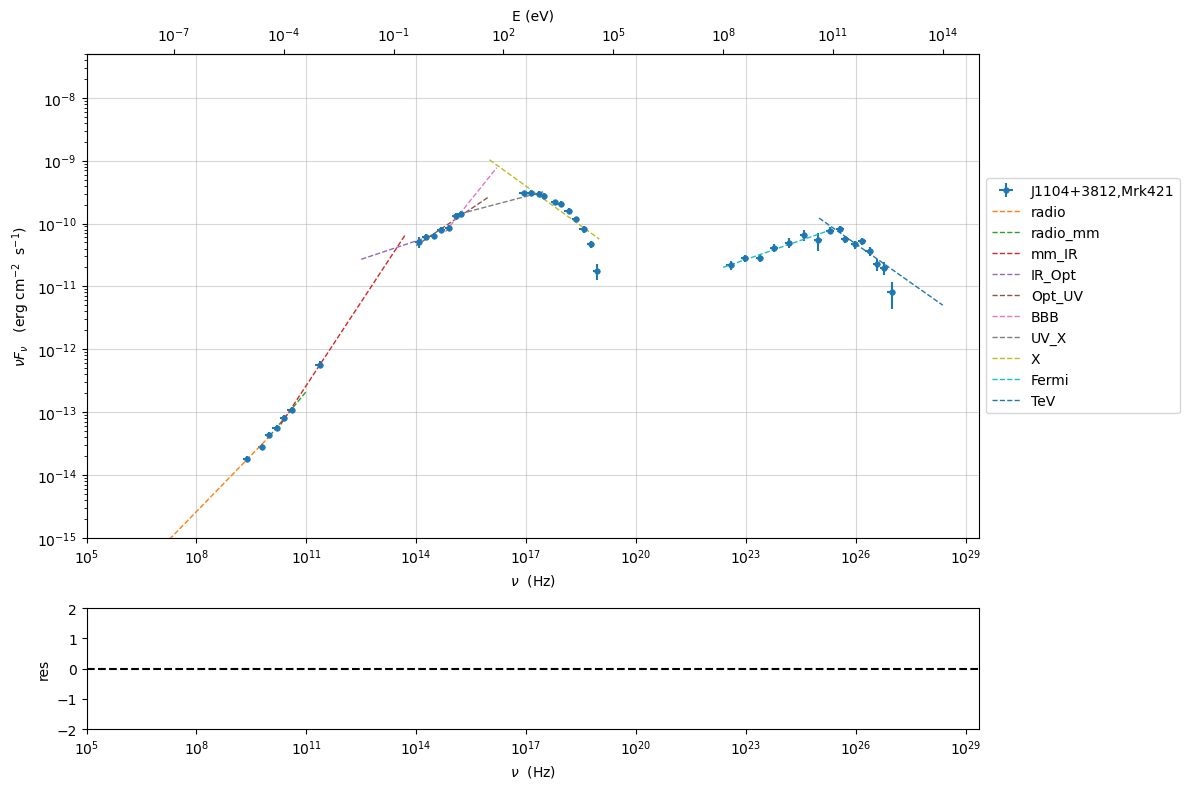

In [7]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=5E-8)

### sed shaper

In [8]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.585748e-01,-1.585748e-01,6.470535e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.089513e-02,-1.089513e-02,9.764985e-04,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.673177e+01,1.673177e+01,2.478677e-02,--,1.667298e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.489417e+00,-9.489417e+00,1.853260e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.673177e+01 (err=+2.478677e-02)  nuFnu_p=-9.489417e+00 (err=+1.853260e-02) curv.=-1.585748e-01 (err=+6.470535e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit
====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.971111e-01,-1.971111e-01,2.679732e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.037544e-02,-4.037544e-02,2.119803e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.521789e+01,2.521789e+01,1.198160e-01,--,2.529262e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.012535e+01,-1.012535e+01,2.996508e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.521789e+01 (err=+1.198160e-01)  nuFnu_p=-1.012535e+01 (err=+2.996508e-02) curv.=-1.971111e-01 (err=+2.679732e-02)



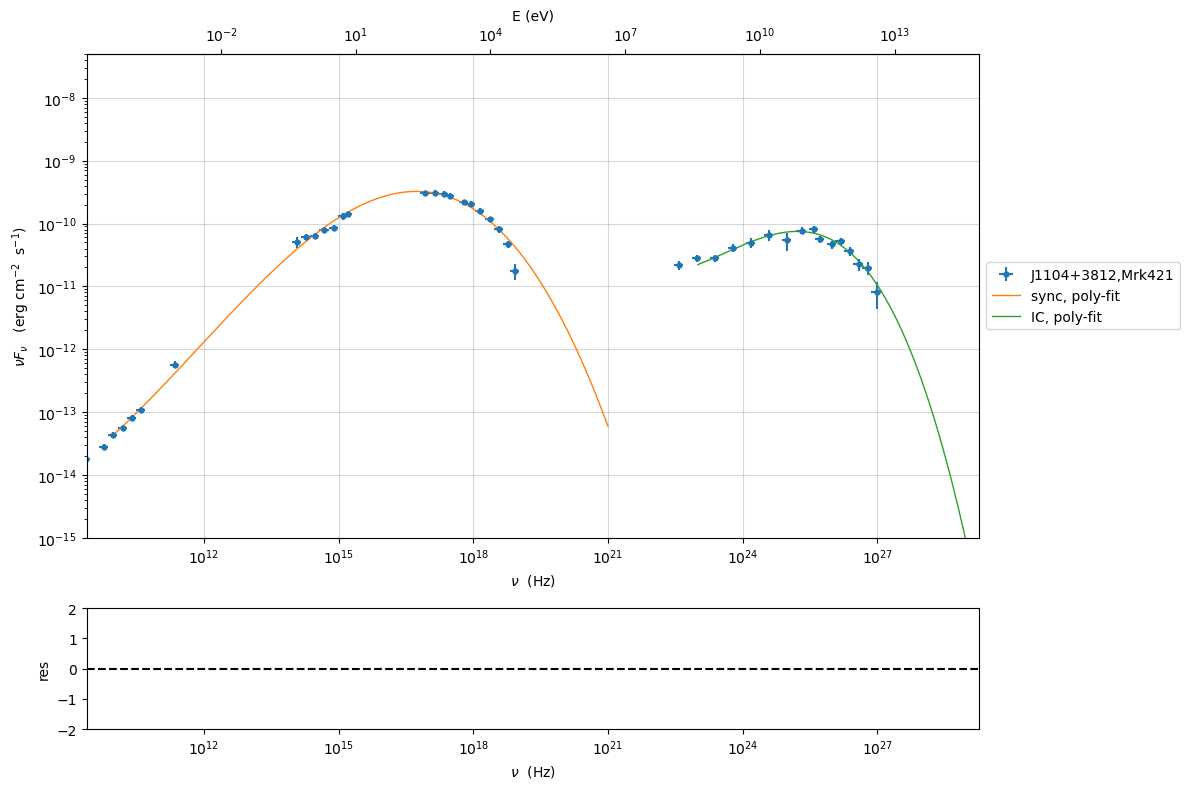

In [9]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15,y_max=5E-8)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [10]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***

===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,6.545152e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.333017e+04,1.000000e+00,1.000000e+09,False,False


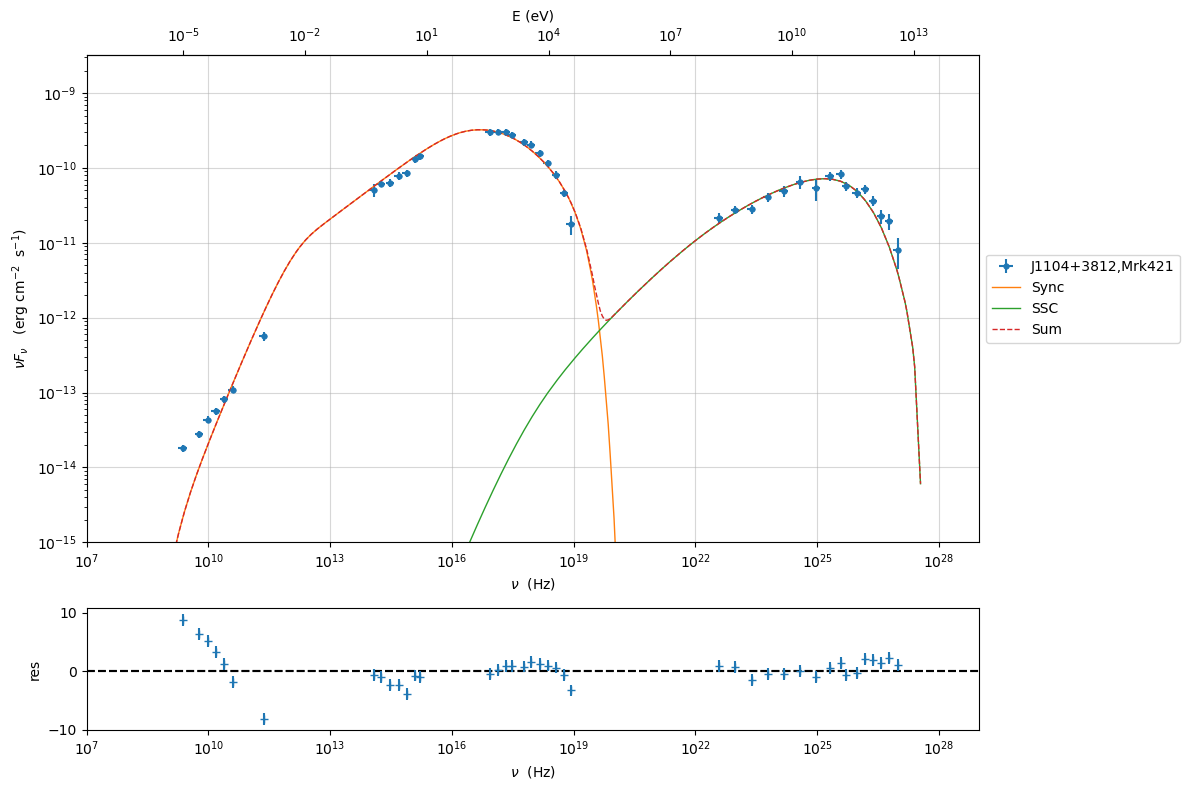

In [11]:
prefit_jet.eval()
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-15,x_min=1E7,x_max=1E29)

## Model fitting procedure

### Model fitting with LSB

In [12]:
from jetset.minimizer import fit_SED,ModelMinimizer

from jetset.model_manager import  FitModel
from jetset.jet_model import Jet


if you want to fit the `prefit_model` you can load the saved one (this allows you to save time) ad pass it to the `FitModel` class

In [13]:
prefit_jet=Jet.load_model('prefit_jet.pkl')
fit_model_lsb=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None) 


===> setting C threads to 12


OR use the one generated above

In [14]:
fit_model=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None) 

In [15]:
fit_model.show_model_components()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------


There is only one component, whit name `jet_leptonic`, that refers to the `prefit_jet` model component

We now set the gamma grid size to 200, ad we set `composite_expr`, anyhow, since we have only one component this step could be skipped

In [16]:
fit_model.jet_leptonic.set_gamma_grid_size(200)
fit_model.composite_expr='jet_leptonic'

#### Freezeing parameters and setting fit_range intervals

These methods are alternative and equivalent ways to access a model component for setting parameters state and values 


a) passing as first argument, of the method, the model component `name`

b) passing as first argument, of the method, the model component `object`

c) accessing the model component member of the composite model class 

In [17]:
#a
fit_model.freeze('jet_leptonic','z_cosm')
fit_model.freeze('jet_leptonic','R_H')
#b
fit_model.freeze(prefit_jet,'R')
#c
fit_model.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]




#### Building the ModelMinimizer object

Now we build a `lsb` model minimizer and run the fit method

In [18]:
model_minimizer=ModelMinimizer('lsb')


**Since the pre-fit model was very close to the data, we degrade the model in order to provide a more robust benchmark to the fitter, but this is not required!!!**

In [19]:
fit_model.jet_leptonic.parameters.N.val=1
fit_model.jet_leptonic.parameters.r.val=1.0
fit_model.jet_leptonic.parameters.beam_obj.val=20
fit_model.eval()

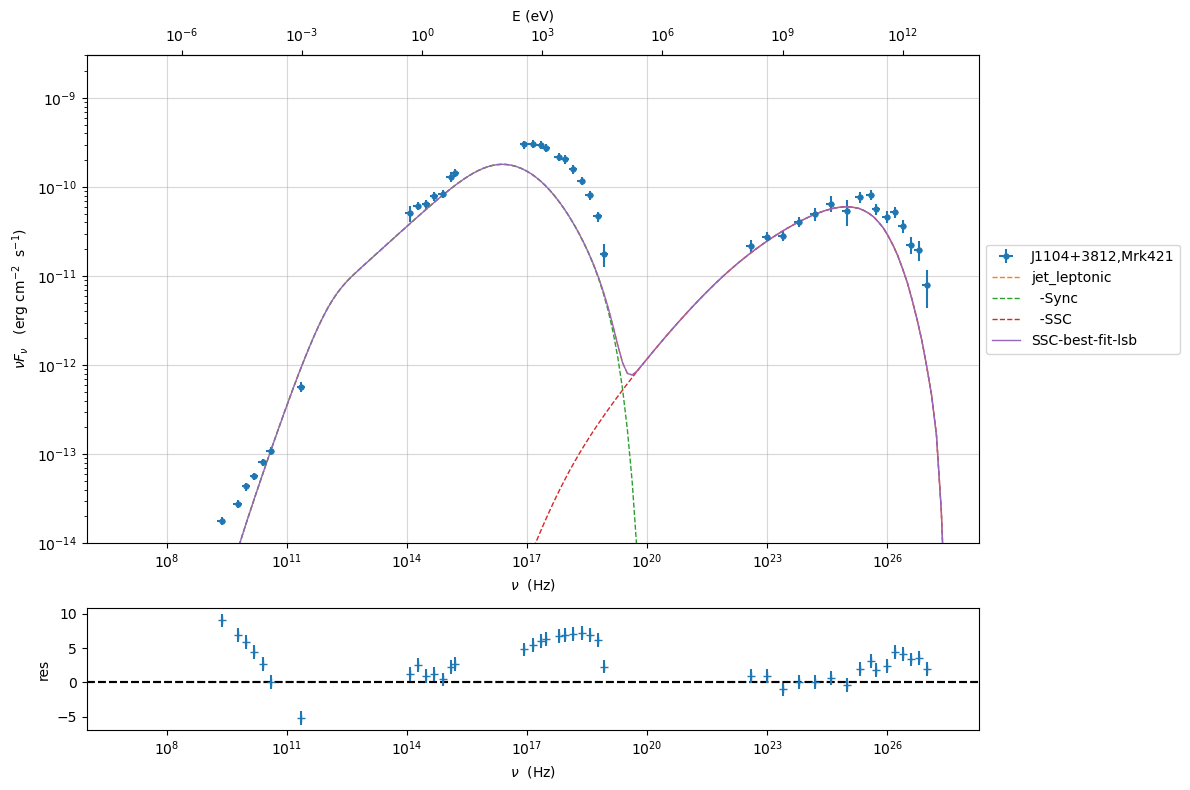

In [20]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,200)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [21]:
best_fit_res=model_minimizer.fit(fit_model,
                                     sed_data,
                                     1E11,
                                     1E29,
                                     fitname='SSC-best-fit-minuit',
                                     repeat=1)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 


0it [00:00, ?it/s]

- best chisq=2.72311e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,6.477165e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,8.714388e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,5.375875e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.085231e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.185631e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,5.620899e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,True
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.027433e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=573
mesg=


'`ftol` termination condition is satisfied.'

dof=27
chisq=27.231050, chisq/red=1.008557 null hypothesis sig=0.451384

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,6.477165e+02,6.477165e+02,8.763882e+01,--,4.697542e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,8.714388e+05,8.714388e+05,4.647860e+04,--,1.373160e+06,1.000000e+00,1.000000e+15,False
jet_leptonic,N,5.375875e-01,5.375875e-01,3.173721e-02,--,1.000000e+00,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,3.085231e+04,3.085231e+04,1.231389e+04,--,3.333017e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.185631e+00,2.185631e+00,7.744080e-02,--,2.183468e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,5.620899e-01,5.620899e-01,9.878160e-02,--,1.000000e+00,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.460321e+16,--,--,--,3.460321e+16,3.162278e+15,3.162278e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,5.027433e-02,5.027433e-02,5.893700e-03,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




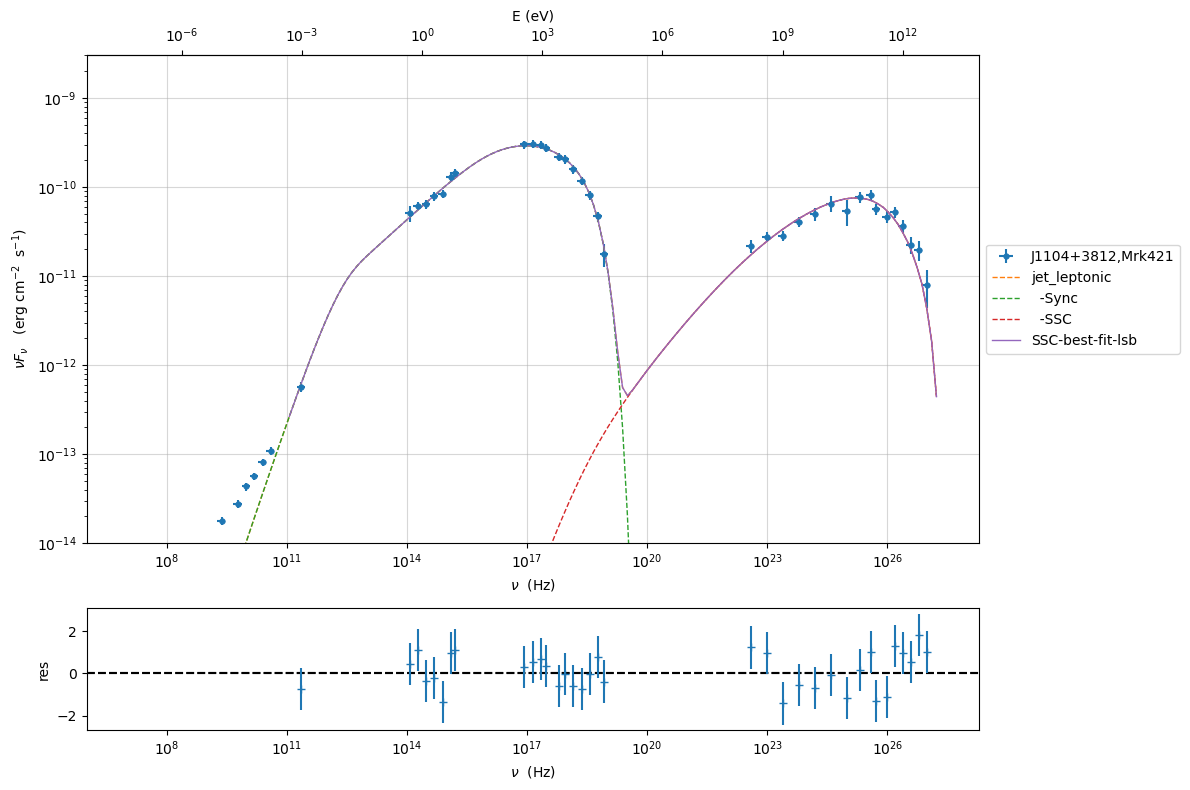

In [22]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,200)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

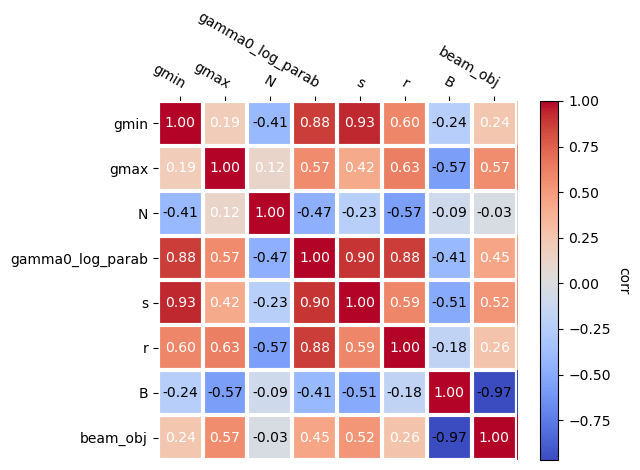

In [23]:
p=model_minimizer.plot_corr_matrix()

#### saving fit model, model minimizer

We can save all the fit products to be used later.

In [24]:

best_fit_res.save_report('SSC-best-fit-lsb.pkl')
model_minimizer.save_model('model_minimizer_lsb.pkl')
fit_model.save_model('fit_model_lsb.pkl')

### Model fitting with Minuit

To run the ``minuit`` minimizer we will use the same `prefit_jet` model used for `lsb`

In [25]:
from jetset.minimizer import fit_SED,ModelMinimizer
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_minuit=Jet.load_model('prefit_jet.pkl')
jet_minuit.set_gamma_grid_size(200)
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=None) 

===> setting C threads to 12


When using minuit, providing `fit_range` to parameters with large physical boundaries, such s 'R' or emitters Lorentz factors, is advised. 

In [26]:

fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.freeze('jet_leptonic','R')
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[5E15,1E17]
fit_model_minuit.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit.jet_leptonic.parameters.gmax.fit_range=[5E5,1E7]
fit_model_minuit.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,1E5]

fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5,50]


Since the pre-fit model was very close to the data, we degrade the model in order to prove a more robust benchmark to the fitter

In [27]:
fit_model_minuit.jet_leptonic.parameters.N.val=1
fit_model_minuit.jet_leptonic.parameters.r.val=1.0
fit_model_minuit.jet_leptonic.parameters.beam_obj.val=20
fit_model_minuit.eval()

In [28]:
model_minimizer_minuit=ModelMinimizer('minuit')


In [29]:
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,
                                           sed_data,
                                           1E11,
                                           1E29,
                                           fitname='SSC-best-fit-minuit',
                                           max_ev=10000,
                                           repeat=2)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=2.88559e+01

fit run: 1
- old chisq=2.88559e+01


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=2.25297e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,8.459850e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,9.786619e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,4.821025e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,7.202800e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.329220e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,8.433724e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,True
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,4.079311e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=687
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 22.53                      │              Nfcn = 687              │
│ EDM = 1.74 (Goal: 0.0002)        │           time = 11.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │845.984955 │ 0.000010  │            │            │   10    │  1000   │       │
│ 1 │ par_1 │978.6619e3 │ 0.0032e3  │            │            │ 500000  │  1e+07  │       │
│ 2 │ par_2 │482.1025e-3│ 0.0010e-3 │            │            │    0    │         │       │
│ 3 │ par_3 │   72e3    │    4e3    │            │            │  1000   │ 100000  │       │
│ 4 │ par_4 │ 2.329220  │ 0.000008  │            │            │   -10   │   10    │       │
│ 5 │ par_5 │843.3724e-3│ 0.0006e-3 │            │            │   -15   │   15    │       │
│ 6 │ par_6 │40.7931e-3 │ 0.0024e-3 │            │            │    0    │         │       │
│ 7 │ par_7 │ 25.31609  │  0.00004  │            │            │    5    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=27
chisq=22.529679, chisq/red=0.834433 null hypothesis sig=0.710002

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,8.459850e+02,8.459850e+02,1.043024e-05,--,4.697542e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,9.786619e+05,9.786619e+05,3.166646e+00,--,1.373160e+06,5.000000e+05,1.000000e+07,False
jet_leptonic,N,4.821025e-01,4.821025e-01,1.049228e-06,--,1.000000e+00,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,7.202800e+04,7.202800e+04,4.302553e+03,--,3.333017e+04,1.000000e+03,1.000000e+05,False
jet_leptonic,s,2.329220e+00,2.329220e+00,7.853562e-06,--,2.183468e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,8.433724e-01,8.433724e-01,5.638138e-07,--,1.000000e+00,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.460321e+16,--,--,--,3.460321e+16,5.000000e+15,1.000000e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,4.079311e-02,4.079311e-02,2.411677e-06,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




note that this plot refers to the latest fit trial, in case, please consider storing the plot within a list in the  fit loop 

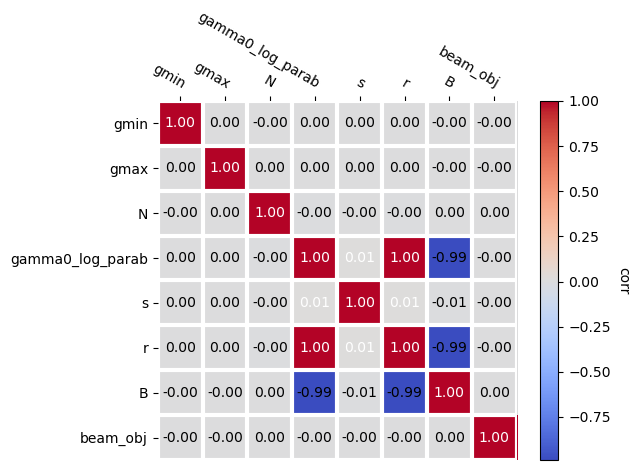

In [30]:
p=model_minimizer_minuit.plot_corr_matrix()

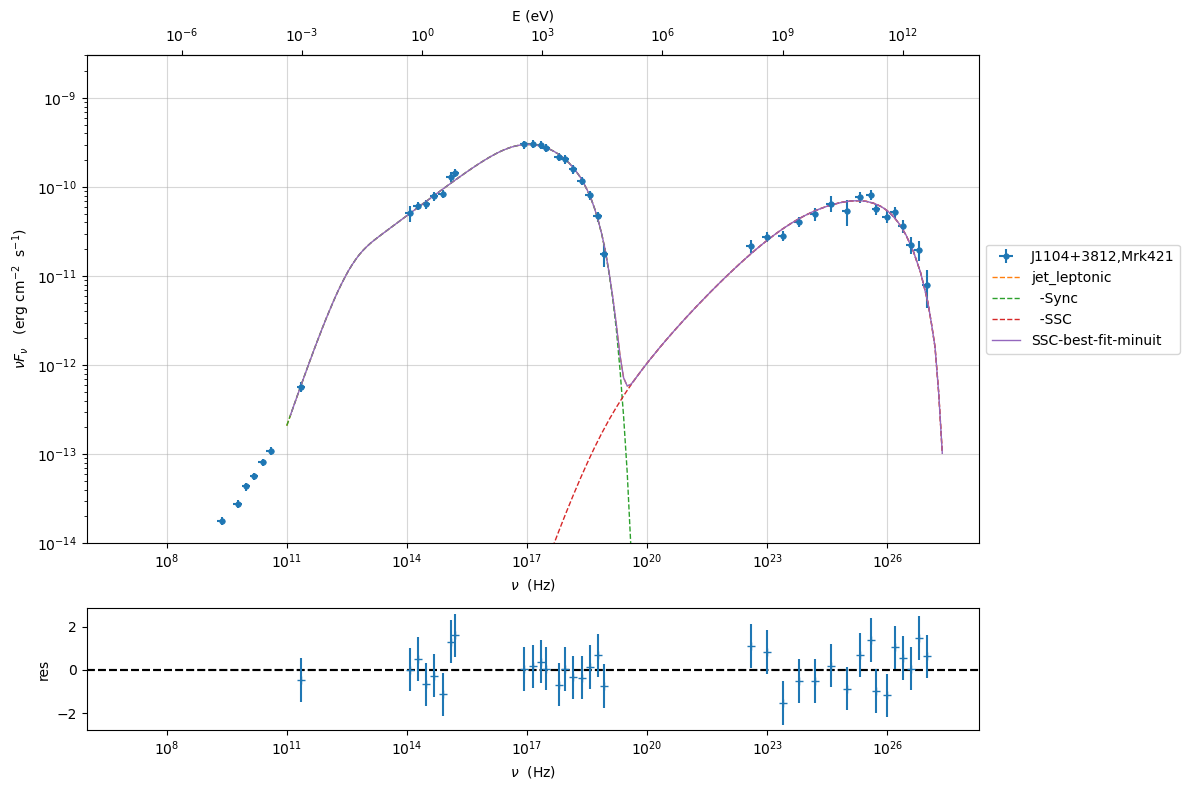

In [31]:
%matplotlib inline
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

#### saving fit model, model minimizer

In [32]:
best_fit_minuit.save_report('SSC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

You can obtain profile and contours, but this is typically time consuming. In any case, better results can be achieved using the MCMC approach (discussed in next section).
For further information regarding minuit please refer to https://iminuit.readthedocs.io

you can use also minos contour and profile, in this case the computational time is even longer:

## MCMC sampling

### creating and setting the sampler

In [33]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


In [34]:
model_minimizer_minuit = ModelMinimizer.load_model('model_minimizer_minuit.pkl')

mcmc=McmcSampler(model_minimizer_minuit)


===> setting C threads to 12


In [35]:
labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.set_labels(use_labels_dict=use_labels_dict)

In [36]:
mcmc.set_bounds(bound=5.0,bound_rel=True)

par: N  best fit value:  0.48210245803309054  mcmc bounds: [0, 2.892614748198543]
par: B  best fit value:  0.04079310894281457  mcmc bounds: [0, 0.24475865365688743]
par: beam_obj  best fit value:  25.316091554006853  mcmc bounds: [5, 50]
par: s  best fit value:  2.329220357129224  mcmc bounds: [-9.316881428516895, 10]
par: gamma0_log_parab  best fit value:  72028.00420425336  mcmc bounds: [1000.0, 100000.0]


In [37]:
mcmc.run_sampler(nwalkers=20, burnin=50,steps=500,progress='notebook')

===> setting C threads to 12
mcmc run starting



  0%|          | 0/500 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 204.27 seconds


### plotting the posterior corner plot

printout the labels

In [38]:
mcmc.labels

['N', 'B', 'beam_obj', 's', 'gamma0_log_parab']

To have a better rendering on the scatter plot, we redefine the plot labels

In [39]:
mcmc.set_plot_label('N',r'$N$')
mcmc.set_plot_label('B',r'$B$')
mcmc.set_plot_label('beam_obj',r'$\delta$')
mcmc.set_plot_label('s',r'$s$')
mcmc.set_plot_label('gamma0_log_parab',r'$\gamma_0$')

the code below lets you tuning the output

1) mpl.rcParams['figure.dpi'] if you increase it you get a better definition
2) title_fmt=".2E" this is the format for python, 2 significant digits, scientific notation
3) title_kwargs=dict(fontsize=12) you can change the fontsize

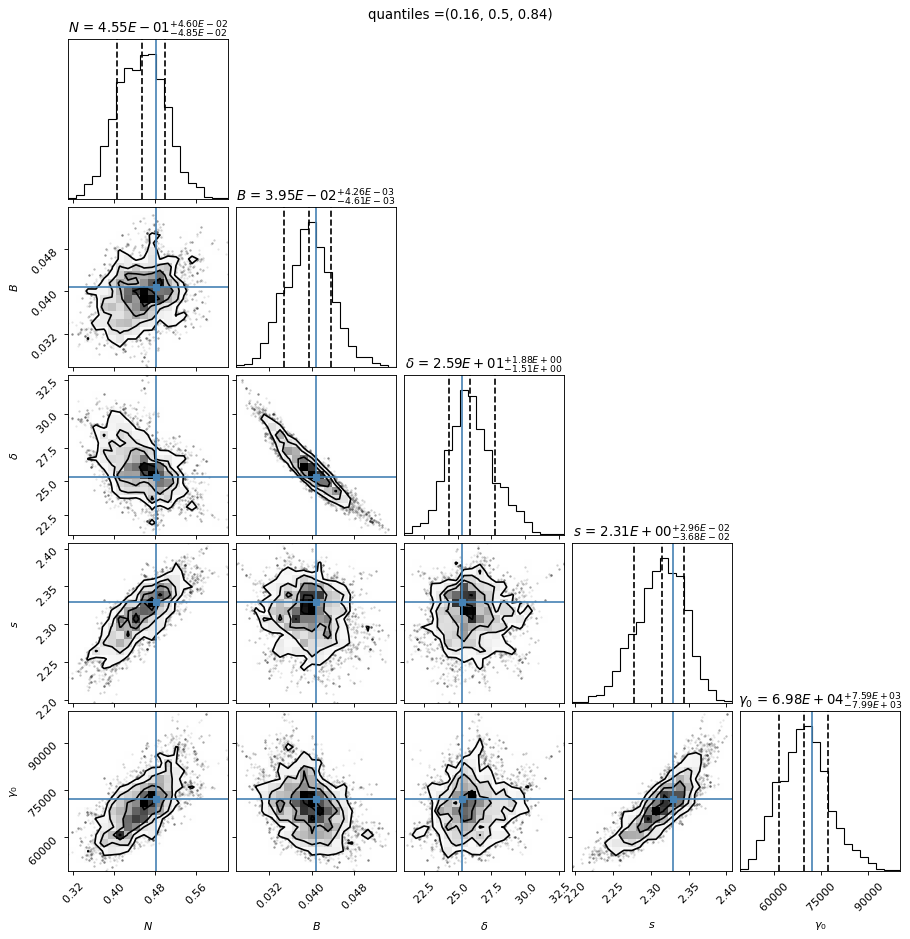

In [40]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
f=mcmc.corner_plot(quantiles=(0.16, 0.5, 0.84),title_kwargs=dict(fontsize=12),title_fmt=".2E",use_math_text=True)


In [41]:
print(mcmc.acceptance_fraction)

0.4937


### plotting the model

To plot the sampled model range against the input best-fit model

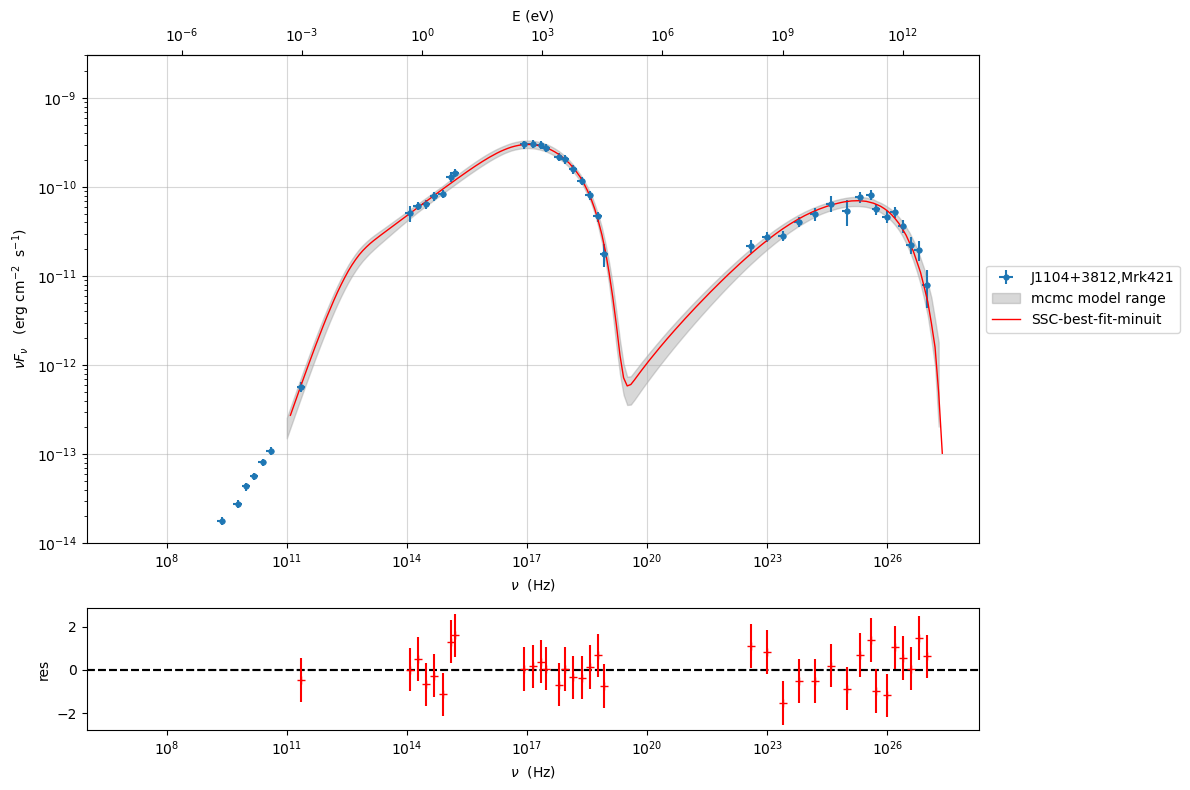

In [42]:
mpl.rcParams['figure.dpi'] = 80
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11,1E29],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

To plot the sampled model range,providing quantiles, against the input best-fit model, providing quantiles

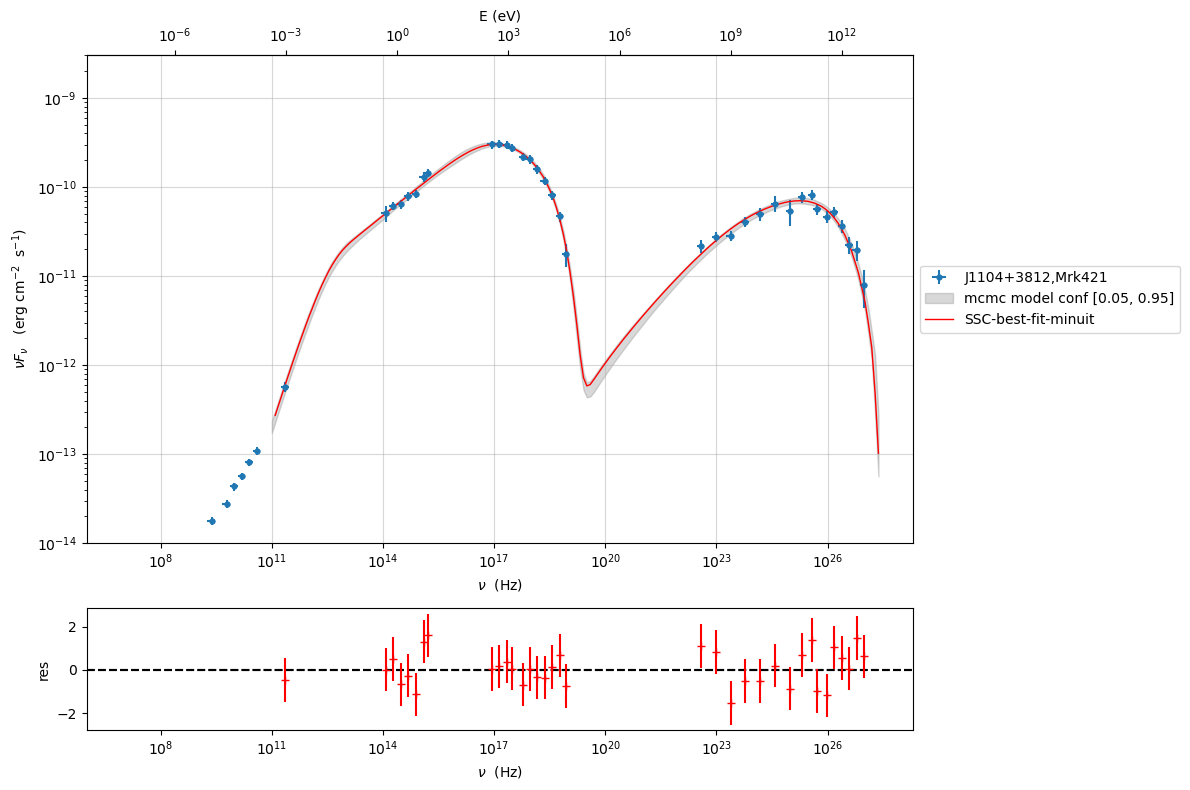

In [43]:
mpl.rcParams['figure.dpi'] = 80
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11, 2E29],size=100,quantiles=[0.05,0.95])
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

To plot the sampled model range,providing quantiles, against the mcmc model at 0.5 quantile (``plot_mcmc_best_fit_model==True`` provides the 0.5 quantile sampled model)

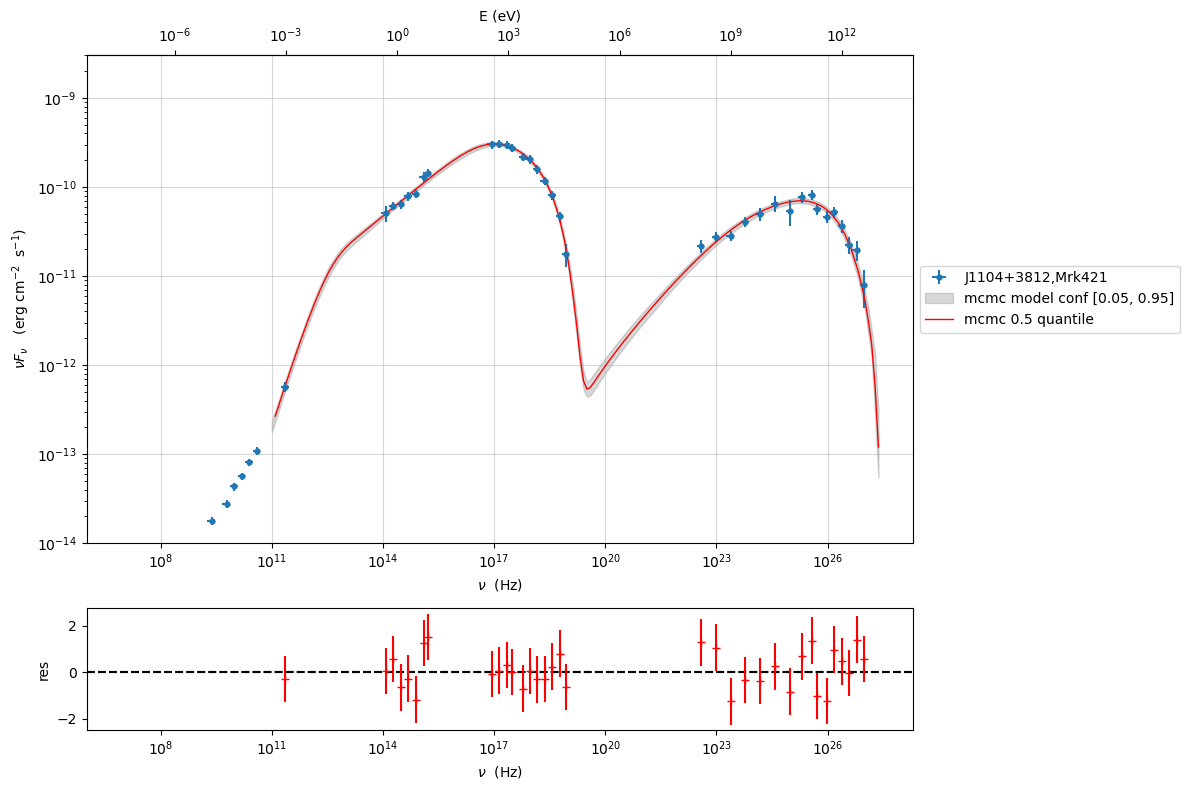

In [44]:
mpl.rcParams['figure.dpi'] = 100
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11, 1E29],size=100,quantiles=[0.05,0.95], plot_mcmc_best_fit_model=True)

p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

### plotting chains and individual posteriors

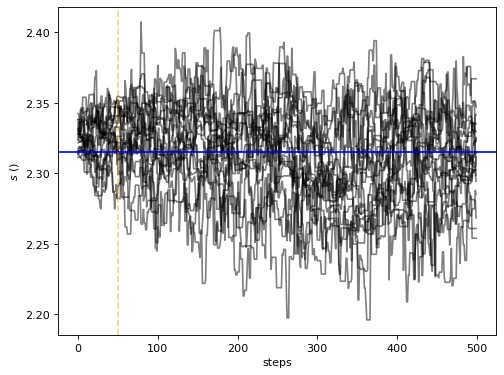

In [45]:
mpl.rcParams['figure.dpi'] = 80
f=mcmc.plot_chain(p='s',log_plot=False)
plt.tight_layout()

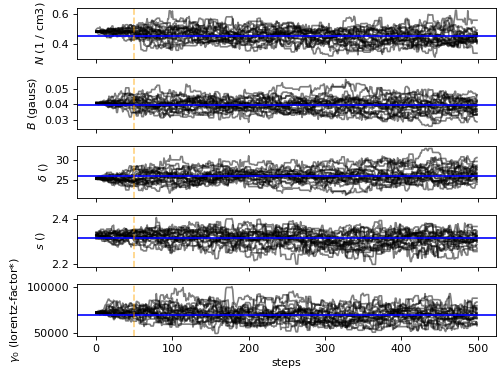

In [46]:
mpl.rcParams['figure.dpi'] = 80
f=mcmc.plot_chain(log_plot=False)
plt.tight_layout()

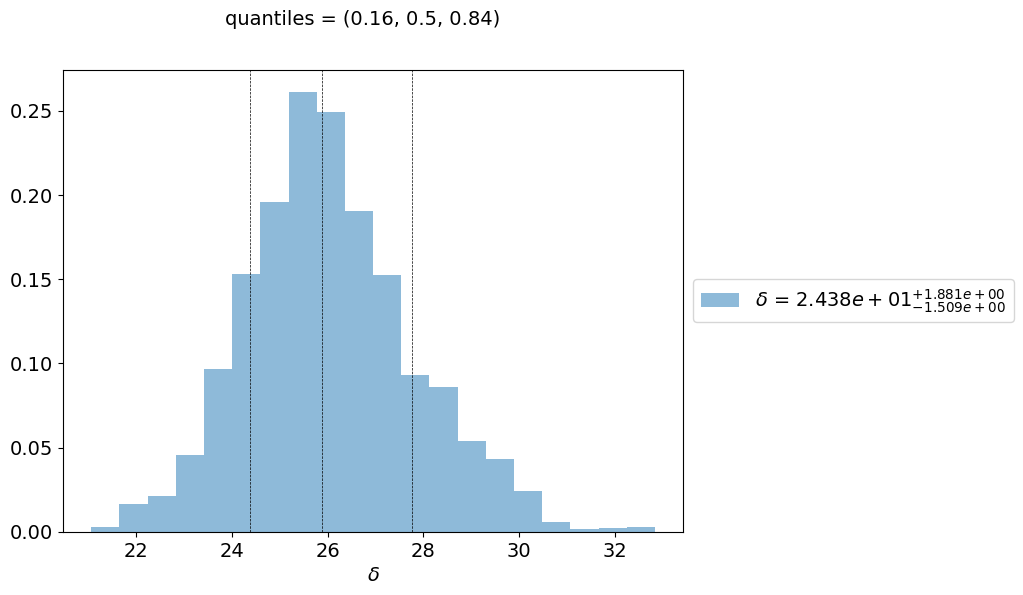

In [47]:

f=mcmc.plot_par('beam_obj',figsize=(8,6))
mpl.rcParams['figure.dpi'] = 80

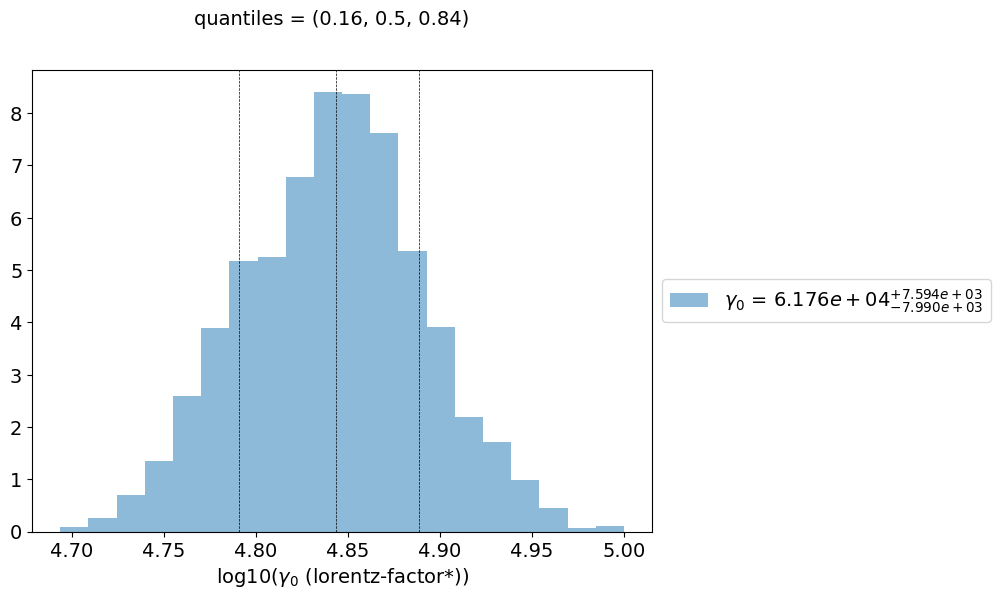

In [48]:
mpl.rcParams['figure.dpi'] = 80
f=mcmc.plot_par('gamma0_log_parab',log_plot=True,figsize=(8,6))

## Save and reuse MCMC

In [49]:
mcmc.save('mcmc_sampler.pkl')

In [50]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_401.pkl')
ms=McmcSampler.load('mcmc_sampler.pkl')

import matplotlib as mpl


===> setting C threads to 12
===> setting C threads to 12


In [51]:
ms.model.name

'SSC-best-fit-minuit'

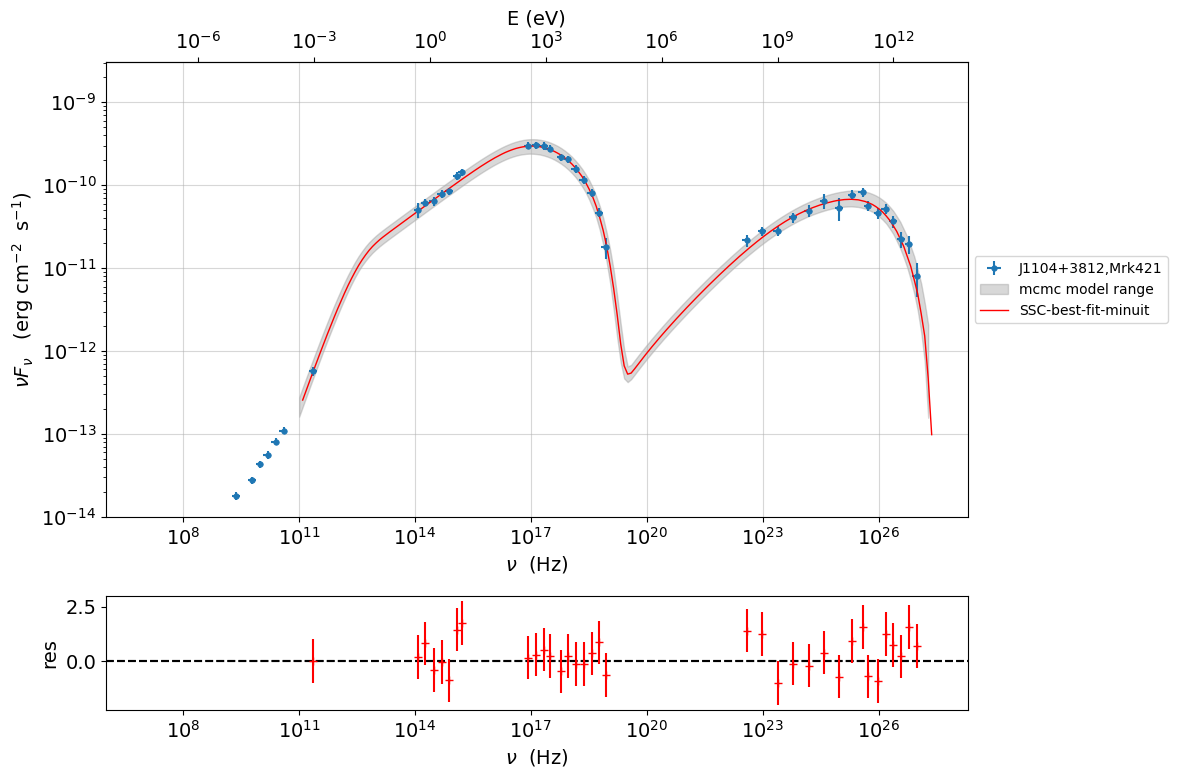

In [52]:
mpl.rcParams['figure.dpi'] = 80
p=ms.plot_model(sed_data=sed_data,fit_range=[1E11, 1E29],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

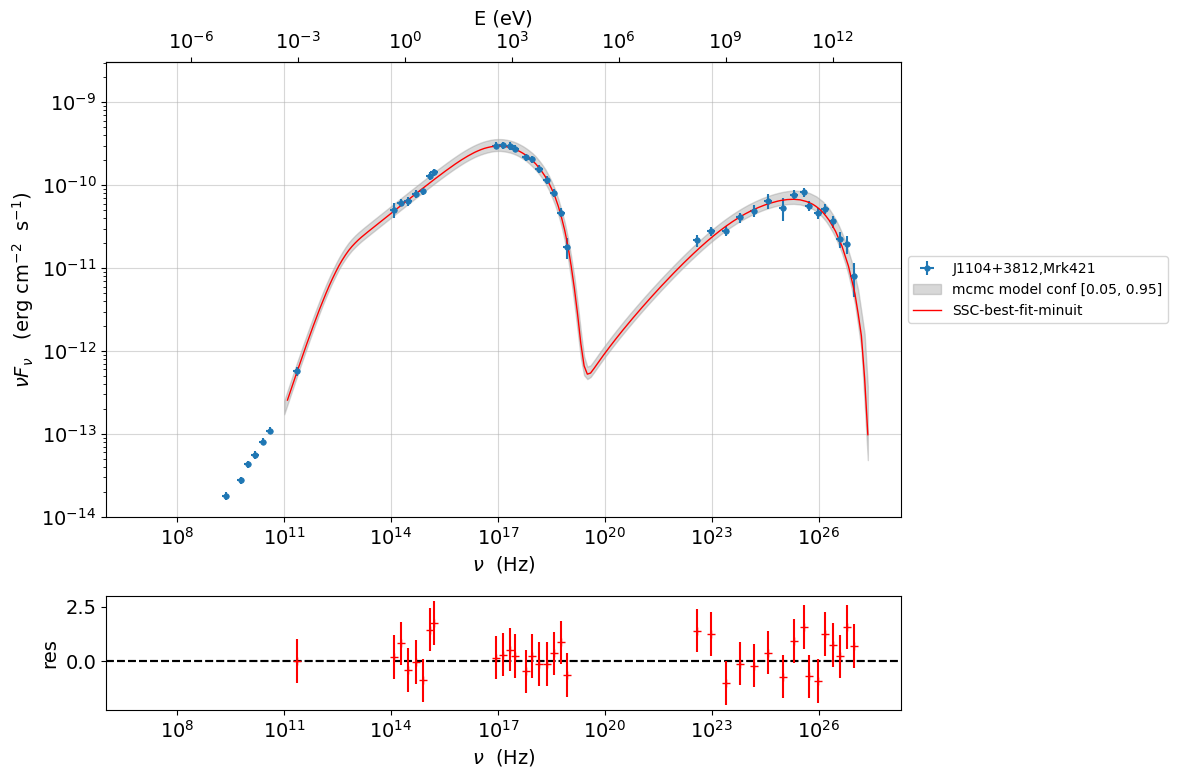

In [53]:
mpl.rcParams['figure.dpi'] = 80
p=ms.plot_model(sed_data=sed_data,fit_range=[1E11, 1E29],size=100,quantiles=[0.05,0.95])

p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

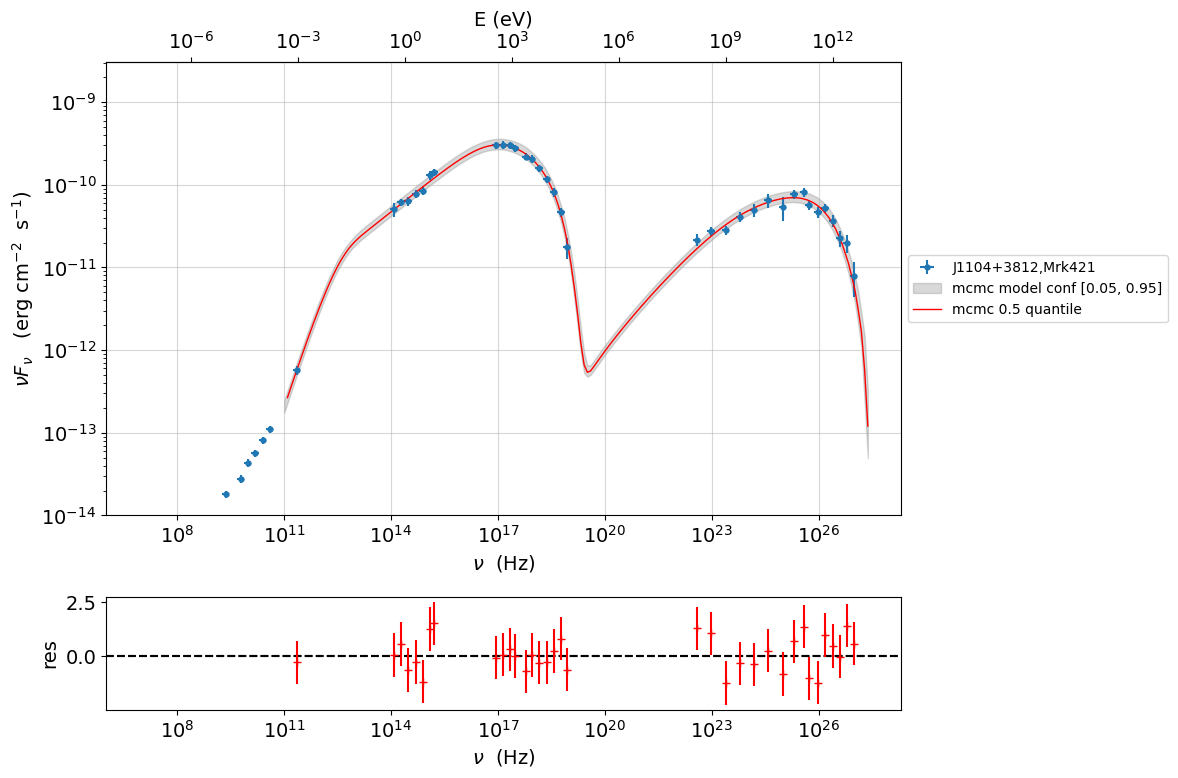

In [54]:
mpl.rcParams['figure.dpi'] = 80
p=ms.plot_model(sed_data=sed_data,fit_range=[1E11, 1E29],size=100,quantiles=[0.05,0.95],plot_mcmc_best_fit_model=True)

p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

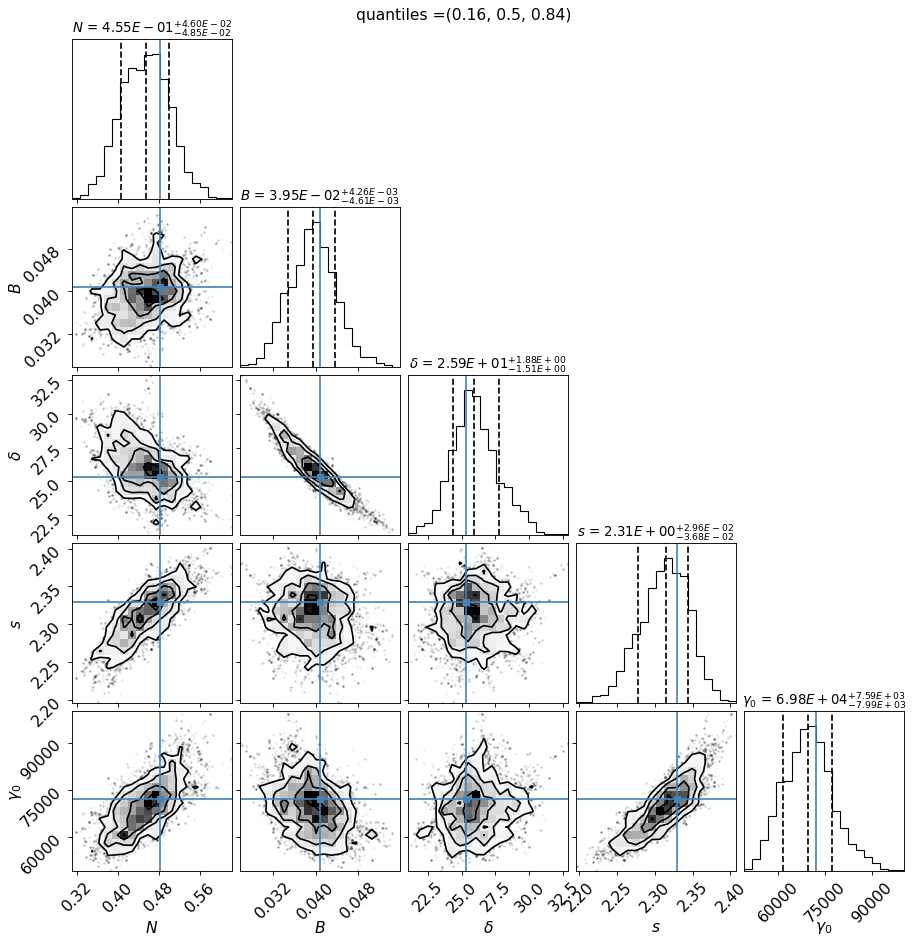

In [55]:
mpl.rcParams['figure.dpi'] = 80
f=ms.corner_plot(quantiles=(0.16, 0.5, 0.84),title_kwargs=dict(fontsize=12),title_fmt=".2E",use_math_text=True)

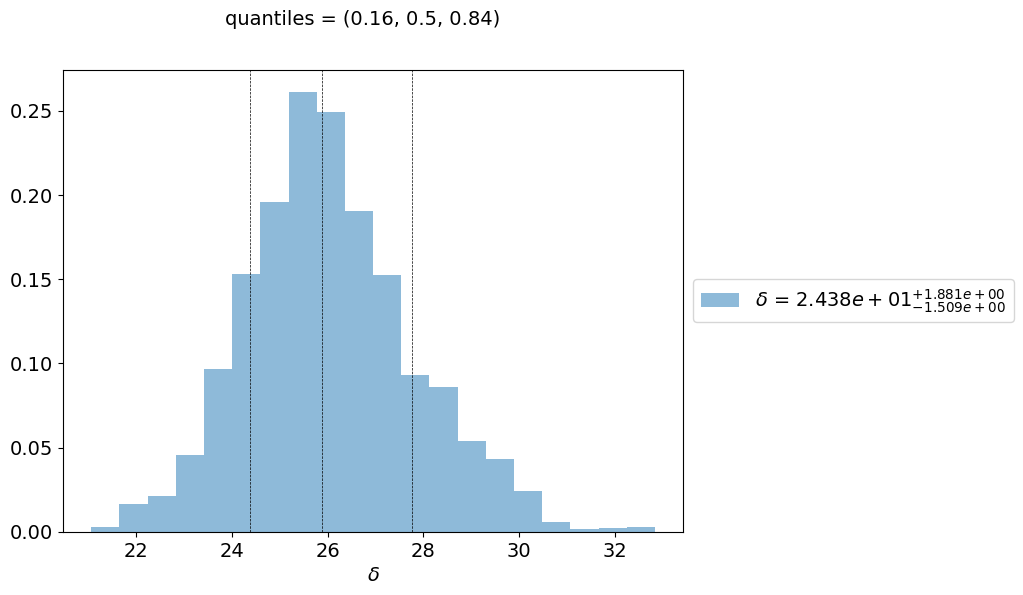

In [56]:
mpl.rcParams['figure.dpi'] = 80
f=ms.plot_par('beam_obj',log_plot=False,figsize=(8,6))

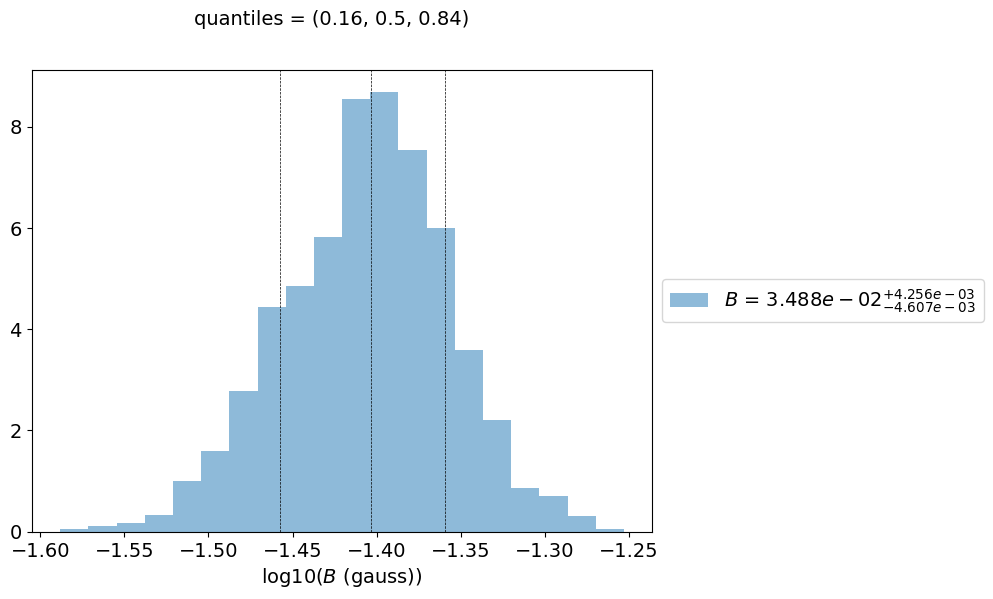

In [57]:
f=ms.plot_par('B',log_plot=True,figsize=(8,6))

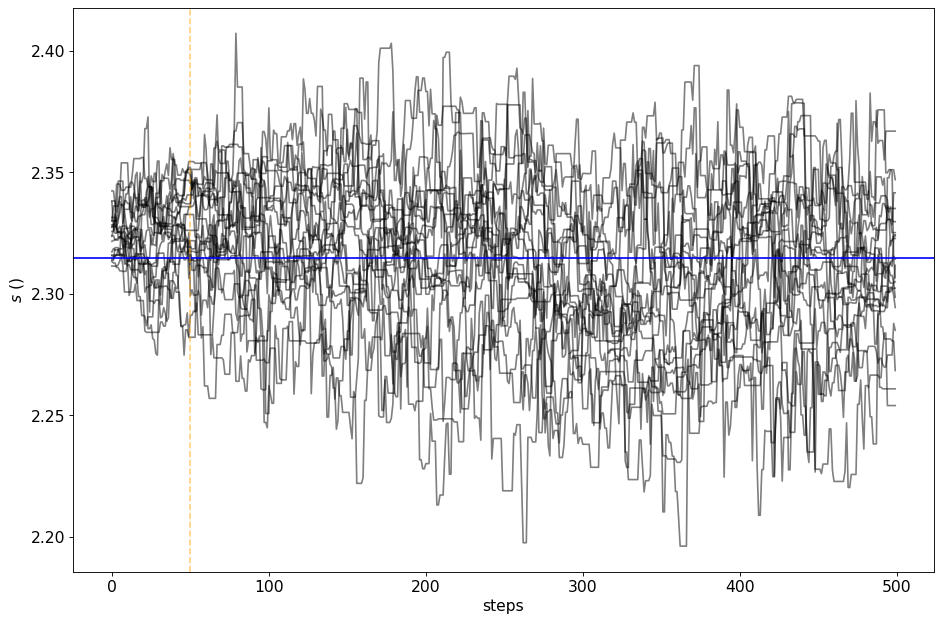

In [58]:
mpl.rcParams['figure.dpi'] = 80
f=ms.plot_chain(p='s',log_plot=False)
plt.tight_layout()

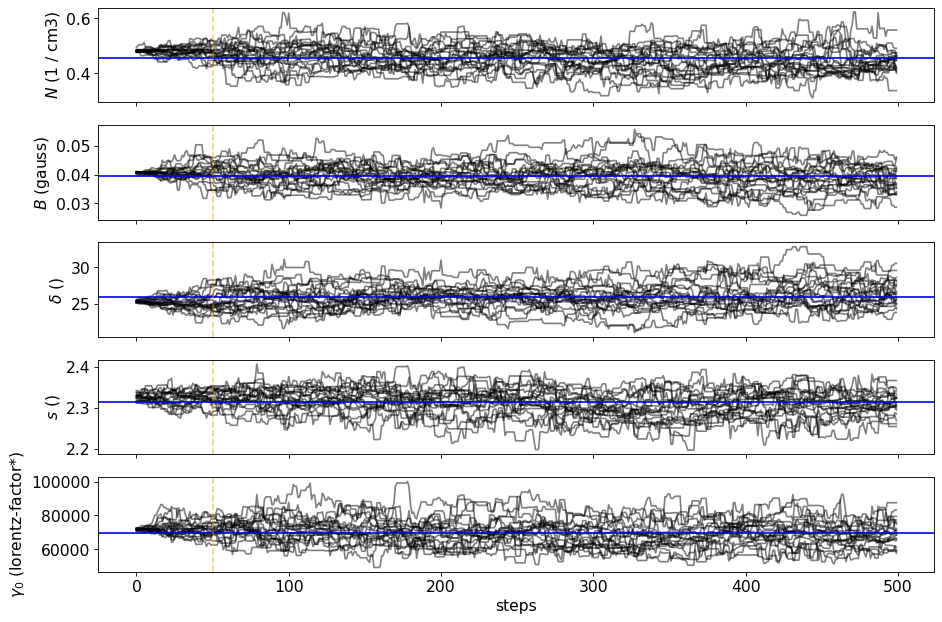

In [59]:
f=ms.plot_chain(log_plot=False)
plt.tight_layout()
mpl.rcParams['figure.dpi'] = 80